<a href="https://colab.research.google.com/github/MothSleath/EmbeddedAI/blob/main/TP_IA_EMBARQUEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
df = pd.read_csv('ai4i2020.csv')

# Affichage des 5 premières lignes du DataFrame
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

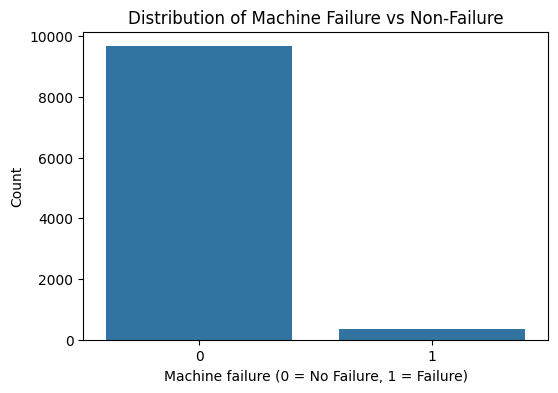

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Machine failure', data=df)
plt.title("Distribution of Machine Failure vs Non-Failure")
plt.xlabel("Machine failure (0 = No Failure, 1 = Failure)")
plt.ylabel("Count")
plt.show()

**ANALYSIS QUESTION:** What do you observe?

La distribution montre qu’il existe un net déséquilibre entre les observations de machines en panne et celles qui ne le sont pas. Concrètement, la majorité des données correspond à des machines sans panne (valeur 0), tandis que la part de machines en panne (valeur 1) est beaucoup plus faible.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Ce déséquilibre (class imbalance) risque de biaiser l’apprentissage du modèle. Concrètement, un modèle non ajusté aura tendance à prédire majoritairement l’absence de panne (classe majoritaire), ce qui peut conduire à une forte diminution du rappel (recall) et du F1-score pour la classe minoritaire (panne). Il sera donc nécessaire de mettre en place des stratégies de rééquilibrage (telles que l’oversampling, l’undersampling ou un ajustement des poids) pour améliorer la qualité des prédictions sur la classe minoritaire.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-4-db8c9968b2fc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="Blues")


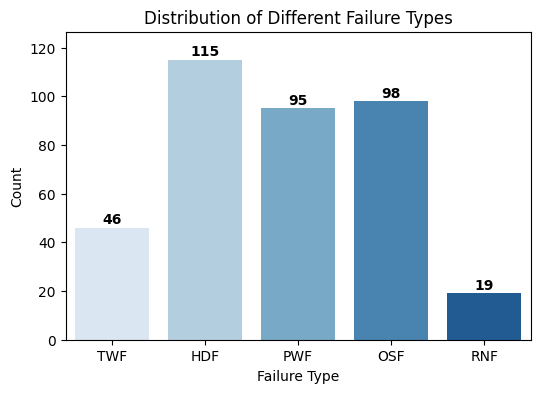

In [4]:
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

# Calcul du nombre total de pannes pour chaque type
failure_counts = df[failure_types].sum()

# Création du bar chart
plt.figure(figsize=(6, 4))
bars = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="Blues")

# Ajout des valeurs exactes au-dessus de chaque barre
for i, value in enumerate(failure_counts.values):
    plt.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontweight='bold')

plt.title("Distribution of Different Failure Types")
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.ylim(top=failure_counts.max() * 1.1)  # Pour laisser de l'espace au texte
plt.show()

**ANALYSIS QUESTION:** What do you observe?

En observant le bar chart, on constate que :

HDF (Heat Dissipation Failure) est le type de panne le plus fréquent (115 occurrences).
OSF (Overstrain Failure) et PWF (Power Failure) ont également un nombre élevé d’occurrences (98 et 95 respectivement).
TWF (Tool Wear Failure) et surtout RNF (Random Failure) sont moins fréquents, avec 46 occurrences pour TWF et 19 pour RNF.
Cette répartition inégale suggère que certaines catégories de panne (HDF, OSF, PWF) sont surreprésentées par rapport à d’autres (TWF, RNF). Cela peut avoir un impact sur la modélisation et la précision du modèle pour les pannes moins fréquentes.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-6-5f36bedb3d99>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=counts.index, y=counts.values, palette="Blues")


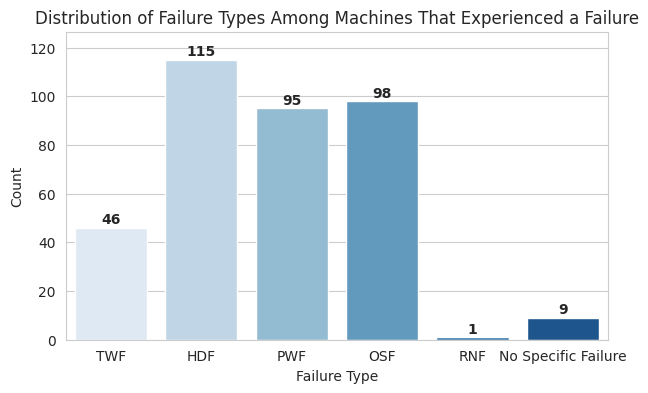

In [6]:
# Filtrer uniquement les machines ayant subi une panne (Machine failure == 1)
df_failures = df[df["Machine failure"] == 1].copy()

# Liste des types de pannes disponibles
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

# Calcul du nombre total de pannes pour chaque type parmi les machines en panne
counts = df_failures[failure_types].sum()

# Calcul du nombre de machines en panne sans type de panne spécifique
no_specific_failure_count = df_failures[
    (df_failures["TWF"] == 0) &
    (df_failures["HDF"] == 0) &
    (df_failures["PWF"] == 0) &
    (df_failures["OSF"] == 0) &
    (df_failures["RNF"] == 0)
].shape[0]

# Ajouter la catégorie "No Specific Failure" en utilisant pd.concat
counts = pd.concat([
    counts,
    pd.Series([no_specific_failure_count], index=["No Specific Failure"])
])

# Visualisation
plt.figure(figsize=(7, 4))
sns.set_style("whitegrid")
bars = sns.barplot(x=counts.index, y=counts.values, palette="Blues")

# Affichage de la valeur exacte au-dessus de chaque barre
for i, value in enumerate(counts.values):
    plt.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontweight='bold')

plt.title("Distribution of Failure Types Among Machines That Experienced a Failure")
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.ylim(top=counts.max() * 1.1)
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Par rapport à la précédente répartition (où l’on comptait toutes les pannes potentielles dans le jeu de données), ce graphique se concentre exclusivement sur les machines qui ont réellement subi une panne (Machine failure == 1). On remarque :

Répartition des pannes spécifiques :

HDF (Heat Dissipation Failure) reste la catégorie la plus fréquente (115), suivie de près par OSF (Overstrain Failure) et PWF (Power Failure).
TWF (Tool Wear Failure) reste moins représentée (46).
RNF (Random Failure) est ici très rare (1 seule occurrence) alors qu’elle pouvait paraître plus fréquente quand on regardait l’ensemble des données (ou qu’elle était mal classifiée).
Apparition de « No Specific Failure » :

Il y a 9 machines qui sont tombées en panne mais dont aucune des colonnes TWF, HDF, PWF, OSF ou RNF n’est activée. Cela signifie que, bien qu’elles soient en panne, elles ne correspondent à aucun des types de pannes connus.
Ce phénomène peut refléter des pannes « non classifiées » ou « incomplètement renseignées » dans le dataset.
Conclusion

Lorsqu’on isole uniquement les machines défaillantes, la majorité de ces défaillances correspondent à l’une des cinq catégories définies (surtout HDF, OSF et PWF).
L’existence d’une catégorie « No Specific Failure » souligne la nécessité d’une meilleure classification ou d’informations supplémentaires pour comprendre et traiter ces pannes non répertoriées.
Enfin, le très faible nombre de RNF (1) chez les machines réellement en panne indique soit qu’il s’agit d’un type de panne très rare, soit qu’il y a un potentiel problème de labellisation.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [7]:
df.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: floa

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Nous utiliserons en entrée : Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm] et Tool wear [min], en excluant UDI et Product ID car ils n’apportent pas d’informations utiles. Pour la sortie, nous prédirons d’abord si la machine tombe en panne (Machine failure, binaire 0/1), puis nous pourrons préciser le type de panne (TWF, HDF, PWF, OSF, RNF) afin de couvrir à la fois la survenue et la nature de la panne.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**QUESTION** Code below the model architecture

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"